In [1]:
## from stefans
# import packages
import gc
import glob
import cmcrameri.cm as ccm
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import os
import matplotlib
import pylab as P

from params import savepath, homedir, allnames, datadir
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('science.mplstyle')

states = gpd.read_file('../data/ne_110m_admin_1_states_provinces.shp')

In [3]:

#Read meta
def _metaread(dir_meta,domain):
 file = "%swrfinput_%s" %(dir_meta,domain)
 data = xr.open_dataset(file)
 lat = data.variables["XLAT"]
 lon = data.variables["XLONG"]
 z = data.variables["HGT"]

 return (lat,lon,z,file)

#WRF reader function
def _wrfread(prefix,dir,var,domain,calendar):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+"."):
   if domain in ii:
    if prefix in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = str ( int ( day[0] ) )
 val1 = day1[0:4]
 val2 = int (day1[4:6])
 val3 = int (day1[6:8])
 print (val1,val2,val3)
 day1_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 day2 = str ( int ( day[nt-1] ) )
 val1 = day2[0:4]
 val2 = int (day2[4:6])
 val3 = int (day2[6:8])
 print (val1,val2,val3)
 day2_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )
 time_array = xr.cftime_range(start=day1_str, end=day2_str,
                              freq="1D", calendar=calendar)


 var_read = xr.DataArray(var_read)
 var_read['day'] = time_array    #year doesn't matter here

 return (var_read.rename({'day': 'time'}))

#WRF tier 3 reader function
def _wrfread_gcm(model,gcm,variant,dir,var,domain,calendar):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+".") and model in ii and gcm in ii \
        and variant in ii and domain in ii:
   if domain in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = str ( int ( day[0] ) )
 val1 = day1[0:4]
 val2 = int (day1[4:6])
 val3 = int (day1[6:8])
 day1_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 day2 = str ( int ( day[nt-1] ) )
 val1 = day2[0:4]
 val2 = int (day2[4:6])
 val3 = int (day2[6:8])
 day2_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 time_array = xr.cftime_range(start=day1_str, end=day2_str,
                              freq="1D", calendar=calendar)   

 var_read = xr.DataArray(var_read)
 var_read['day'] = time_array    #year doesn't matter here

 return (var_read)

def _read_merge(dir,domain,var,gcm,variant,date_start_hist, \
                date_start_ssp,date_end_hist,date_end_ssp,exp,bc,calendar):
    
    dir_x = "%s/%s_%s_historical/postprocess/" %(dir,gcm,variant) + domain + "/"
    
    if bc == True:
        dir_x = "%s/%s_%s_historical_bc/postprocess/" %(dir,gcm,variant) + domain + "/"

    if calendar == '360_day':
        date_end_hist = date_end_hist.split("-")
        date_end_hist = "%s-%s-%s" %(date_end_hist[0],
                                     date_end_hist[1],
                                     int( int(date_end_hist[2]) + 0.0001 - 1) )
        
        date_end_ssp = date_end_ssp.split("-")
        date_end_ssp = "%s-%s-%s" %(date_end_ssp[0],
                                     date_end_ssp[1],
                                     int( int(date_end_ssp[2]) + 0.0001 - 1) )
        
    print (calendar,date_end_hist,date_end_ssp)
    var_wrf = _wrfread_gcm("hist",gcm,variant,dir_x,var,domain,calendar)
    var_hist = var_wrf.sel(day=slice(date_start_hist,date_end_hist))
    dir_x = "%s/%s_%s_%s/postprocess/" %(dir,gcm,variant,exp) + domain + "/"
    
    print (gcm,variant,bc,exp)
    
    if bc == True:
        dir_x = "%s/%s_%s_%s_bc/postprocess/" %(dir,gcm,variant,exp) + domain + "/"

    var_wrf = _wrfread_gcm(exp,gcm,variant,dir_x,var,domain,calendar)
    var_ssp = var_wrf.sel(day=slice(date_start_ssp,date_end_ssp) )
    
    var_combine = xr.concat([var_hist,var_ssp],dim="day").rename({'day': 'time'})
    
    return (var_combine)

def _ComputeMax(array):
    
    #Must consider the increment; not the max value
    
    historical = array.sel(time=slice('1981','2010')).diff('time')
    historical = historical.groupby('time.year').max()
    future = array.sel(time=slice('2070','2100')).diff('time')
    future = future.groupby('time.year').max()
    
    diff_eoc = future.mean('year') - historical.mean('year')
    future = array.sel(time=slice('2040','2070')).diff('time')
    future = future.groupby('time.year').max()
    diff_mid = future.mean('year') - historical.mean('year')

    
    return (diff_eoc.load(), diff_mid.load())
    
print ("Functions loaded")

Functions loaded


In [4]:

gcms_dict = {'d01': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd02': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd03': ['ec-earth3-veg'],
             'd04': ['ec-earth3-veg'],}

variants_dict = {'d01': ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
                         'r1i1p1f1','r1i1p1f1','r2i1p1f2',
                         'r1i1p2f1','r5i1p1f1','r1i1p1f1',],
                 'd02': ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
                         'r1i1p1f1','r1i1p1f1','r2i1p1f2',
                         'r1i1p2f1','r5i1p1f1','r1i1p1f1',],
                 'd03': ['r1i1p1f1'],
                 'd04': ['r1i1p1f1'],}

calendars_dict = {'d01': ['365_day','proleptic_gregorian','proleptic_gregorian',
                         'proleptic_gregorian','365_day','360_day',
                         '365_day','proleptic_gregorian','proleptic_gregorian',],
                 'd02': ['365_day','proleptic_gregorian','proleptic_gregorian',
                         'proleptic_gregorian','365_day','360_day',
                         '365_day','proleptic_gregorian','proleptic_gregorian',],
                 'd03': ['proleptic_gregorian'],
                 'd04': ['proleptic_gregorian'],}

ssps_dict = {'d01': ['ssp370','ssp370','ssp370','ssp370',
                     'ssp370','ssp370','ssp370','ssp370',
                     'ssp370',],
             'd02': ['ssp370','ssp370','ssp370','ssp370',
                     'ssp370','ssp370','ssp370','ssp370',
                     'ssp370',],
             'd03': ['ssp370'],
             'd04': ['ssp370'],}


source_ids = {'access-cm2':'ACCESS-CM2', 
             'cesm2':'CESM2',
             'cnrm-esm2-1':'CNRM-ESM2-1', 
             'canesm5':'CanESM5',
             'ec-earth3':'EC-Earth3',
             'ec-earth3-veg': 'EC-Earth3-Veg',
             'fgoals-g3':'FGOALS-g3', 
             'mpi-esm1-2-lr':'MPI-ESM1-2-LR',
             'ukesm1-0-ll':'UKESM1-0-LL'}

date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"
dir_meta = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'


In [9]:
## functions
def prep_tas():
    tas_ts = pd.read_csv('wrfrun_globalavg_temp.csv', index_col = 0, parse_dates = True)
    mask = (tas_ts['year'] >= 1980) & (tas_ts['year'] <= 2000)
    baseline = tas_ts[mask].groupby('year').mean(numeric_only = True).mean().values[0]
    tas_ts['d_tas'] = tas_ts['tas'] - baseline
    tas_ts = tas_ts.groupby(['year', 'source_id']).mean()
    tas_ds = xr.Dataset.from_dataframe(tas_ts[['d_tas']])
    gc.collect()
    return tas_ds


def make_snow_maps(gcms, variants, ssps, calendars, var = 'snow'):
    keys = []
    snow_BC = {}
    mydir = '/glade/campaign/uwyo/wyom0112/postprocess/'
    print(len(gcms))
    for count, igcm in enumerate(gcms):
        condition = ()
        bc = True
        key = '%s_%s_%s' %(igcm,variants[count],ssps[count])
        read = _read_merge(mydir,domain,var,
                          igcm,variants[count], \
                          date_start_hist,date_start_ssp, \
                          date_end_hist,date_end_ssp,ssps[count],bc,
                          calendars[count])

        snow_BC[key] = read
        keys.append(key)
        gc.collect()
    return snow_BC, keys

def get_mid_eoc_diffs(snow,keys):
    ''' takes approx one minute per gcm'''
    eoc_list = []
    midc_list = []
    for count, igcm in enumerate(keys):
        eoc, midc = _ComputeMax(snow[igcm])
        eoc_list.append(eoc)
        midc_list.append(midc)
        print (igcm)

    eoc_xr = xr.concat(eoc_list,dim='gcm')
    midc_xr = xr.concat(midc_list,dim='gcm')
    gc.collect()
    return midc_xr, eoc_xr

def make_diffs(domain):
    lat1, lon1, z1, file = _metaread(dir_meta,domain)
    lon_wrf = lon1[0,:,:]
    lat_wrf = lat1[0,:,:]
    z_wrf = z1[0,:,:]
    lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
    lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
    z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

    coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                     'lon': (['lat2d','lon2d'], lon_wrf) }
    gcms = gcms_dict[domain]
    variants = variants_dict[domain]
    ssps = ssps_dict[domain]
    calendars = calendars_dict[domain]
    print (len(ssps),len(calendars),len(variants),len(gcms))
    snow_BC, keys = make_snow_maps(gcms, variants, ssps, calendars, var = 'snow')
    midc_xr, eoc_xr = get_mid_eoc_diffs(snow_BC)
    eoc_xr.to_netcdf(f'eoc_snow_BC_{domain}.nc')
    midc_xr.to_netcdf(f'midc_snow_BC_{domain}.nc')
    tas_ds = prep_tas()
    keys = [source_ids[k] for k in gcms]
    my_tas = tas_ds.sel(source_id = keys)
    diff = eoc_xr / tas_xr
    diff = diff.sel(time = slice(2070,2100)).sum(dim ='time')
    diff.to_netcdf(f'diff_eoc_BC_{domain}.nc')
    diff = midc_xr / tas_xr
    diff = diff.sel(time = slice(2040,2070)).sum(dim ='time')
    diff.to_netcdf(f'diff_midc_BC_{domain}.nc')
    gc.collect()
    return

In [10]:
domain = 'd04'
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                 'lon': (['lat2d','lon2d'], lon_wrf) }
gcms = gcms_dict[domain]
variants = variants_dict[domain]
ssps = ssps_dict[domain]
calendars = calendars_dict[domain]
print (len(ssps),len(calendars),len(variants),len(gcms))

snow_BC, keys = make_snow_maps(gcms, variants, ssps, calendars, var = 'snow')
'''
midc_xr, eoc_xr = get_mid_eoc_diffs(snow_BC)
eoc_xr.to_netcdf(f'eoc_snow_BC_{domain}.nc')
midc_xr.to_netcdf(f'midc_snow_BC_{domain}.nc')
tas_ds = prep_tas()
keys = [source_ids[k] for k in gcms]
my_tas = tas_ds.sel(source_id = keys)
diff = eoc_xr / tas_xr
diff = diff.sel(time = slice(2070,2100)).sum(dim ='time')
diff.to_netcdf(f'diff_eoc_BC_{domain}.nc')
diff = midc_xr / tas_xr
diff = diff.sel(time = slice(2040,2070)).sum(dim ='time')
diff.to_netcdf(f'diff_midc_BC_{domain}.nc')
gc.collect()
'''

1 1 1 1
1
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370


"\nmidc_xr, eoc_xr = get_mid_eoc_diffs(snow_BC)\neoc_xr.to_netcdf(f'eoc_snow_BC_{domain}.nc')\nmidc_xr.to_netcdf(f'midc_snow_BC_{domain}.nc')\ntas_ds = prep_tas()\nkeys = [source_ids[k] for k in gcms]\nmy_tas = tas_ds.sel(source_id = keys)\ndiff = eoc_xr / tas_xr\ndiff = diff.sel(time = slice(2070,2100)).sum(dim ='time')\ndiff.to_netcdf(f'diff_eoc_BC_{domain}.nc')\ndiff = midc_xr / tas_xr\ndiff = diff.sel(time = slice(2040,2070)).sum(dim ='time')\ndiff.to_netcdf(f'diff_midc_BC_{domain}.nc')\ngc.collect()\n"

In [11]:
midc_xr, eoc_xr = get_mid_eoc_diffs(snow_BC, keys)

ec-earth3-veg_r1i1p1f1_ssp370


In [12]:
eoc_xr.to_netcdf(f'eoc_snow_BC_{domain}.nc')
midc_xr.to_netcdf(f'midc_snow_BC_{domain}.nc')


In [19]:
tas_ds = prep_tas()
keys = [source_ids[k] for k in gcms]
my_tas = tas_ds.sel(source_id = keys)
diff = eoc_xr / my_tas
diff = diff.sel(year = slice(2070,2100)).sum(dim ='year')
diff.to_netcdf(f'diff_eoc_BC_{domain}.nc')
diff = midc_xr / my_tas
diff = diff.sel(year = slice(2040,2070)).sum(dim ='year')
diff.to_netcdf(f'diff_midc_BC_{domain}.nc')
gc.collect()

/glade/scratch/mcowherd/ipykernel_270745/2052869555.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tas_ts = tas_ts.groupby(['year', 'source_id']).mean()


20

In [176]:
for domain in ['d04']:
    make_diffs(domain)
    print(domain)
    gc.collect()

9 9 9 9
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 True ssp370
360_day 2014-08-30 2100-08-30
ukesm1-0-ll r2i1p1f2 True ssp370
365_day 2014-08-31 2100-08-31
canesm5 r1i1p2f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
access-cm2 r5i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3 r1i1p1f1 True ssp370
ec-earth3-veg_r1i1p1f1_ssp370
cesm2_r11i1p1f1_ssp370
mpi-esm1-2-lr_r7i1p1f1_ssp370
cnrm-esm2-1_r1i1p1f2_ssp370
fgoals-g3_r1i1p1f1_ssp370
ukesm1-0-ll_r2i1p1f2_ssp370
canesm5_r1i1p2f1_ssp370
access-cm2_r5i1p1f1_ssp370
ec-earth3_r1i1p1f1_ssp370


/glade/scratch/mcowherd/ipykernel_117867/2377582069.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tas_ts = tas_ts.groupby(['year', 'source_id']).mean()


d01
9 9 9 9
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 True ssp370
360_day 2014-08-30 2100-08-30
ukesm1-0-ll r2i1p1f2 True ssp370
365_day 2014-08-31 2100-08-31
canesm5 r1i1p2f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
access-cm2 r5i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3 r1i1p1f1 True ssp370
ec-earth3-veg_r1i1p1f1_ssp370
cesm2_r11i1p1f1_ssp370
mpi-esm1-2-lr_r7i1p1f1_ssp370
cnrm-esm2-1_r1i1p1f2_ssp370
fgoals-g3_r1i1p1f1_ssp370
ukesm1-0-ll_r2i1p1f2_ssp370
canesm5_r1i1p2f1_ssp370
access-cm2_r5i1p1f1_ssp370
ec-earth3_r1i1p1f1_ssp370


/glade/scratch/mcowherd/ipykernel_117867/2377582069.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tas_ts = tas_ts.groupby(['year', 'source_id']).mean()


d02
1 1 1 1
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
ec-earth3-veg_r1i1p1f1_ssp370
cesm2_r11i1p1f1_ssp370
mpi-esm1-2-lr_r7i1p1f1_ssp370
cnrm-esm2-1_r1i1p1f2_ssp370
fgoals-g3_r1i1p1f1_ssp370


KeyboardInterrupt: 

['ec-earth3-veg']

In [82]:
%%time

#These files contain all static fields
domain = "d04"
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                 'lon': (['lat2d','lon2d'], lon_wrf) }

gcms = ['ec-earth3-veg']# ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        #'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        #'canesm5','access-cm2','ec-earth3'] #,
        #'miroc6','noresm2-mm','mpi-esm1-2-hr',
        #'taiesm1','giss-e2-1-g','cesm2','cesm2']

variants = ['r1i1p1f1'] #['r11i1p1f1','r7i1p1f1','r1i1p1f2',
          #  'r1i1p1f1','r1i1p1f1','r2i1p1f2',
           # 'r1i1p2f1','r5i1p1f1','r1i1p1f1',]
#            'r1i1p1f1','r1i1p1f1','r7i1p1f1',
#            'r1i1p1f1','r1i1p1f2','r11i1p1f1',
#            'r11i1p1f1']

calendar = ['proleptic_gregorian'] # ['365_day','proleptic_gregorian','proleptic_gregorian',
          #  'proleptic_gregorian','365_day','360_day',
           #  '365_day','proleptic_gregorian','proleptic_gregorian',]
#            'proleptic_gregorian','365_day', 'proleptic_gregorian',
#            '365_day','365_day','365_day','365_day']

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370',] #'ssp370','ssp370','ssp370',
      # 'ssp370','ssp370',
      #  'ssp245','ssp585']

print (len(ssps),len(calendar),len(variants),len(gcms))


p = np.array([1000, 925, 850, 800, 700, 600, 500, 400, 300, 250])
pressure = xr.DataArray(p,dims=['pressure'])

dir = datadir = '/glade/campaign/uwyo/wyom0112/postprocess/'


snow_noBC = {}
snow_BC = {}
snowApril1 = []
snowJan1 = []
snowJul1 = []

keys = []




9 1 1 1
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 False ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
CPU times: user 1.77 s, sys: 786 ms, total: 2.55 s
Wall time: 24.2 s


24754

In [84]:
eoc_snow_BC.to_netcdf('eoc_snow_BC_d04.nc')
midc_snow_BC.to_netcdf('midc_snow_BC_d04.nc')

In [15]:
tas_ts = pd.read_csv('wrfrun_globalavg_temp.csv', index_col = 0, parse_dates = True)
mask = (tas_ts['year'] >= 1980) & (tas_ts['year'] <= 2000)
baseline = tas_ts[mask].groupby('year').mean(numeric_only = True).mean().values[0]
tas_ts['d_tas'] = tas_ts['tas'] - baseline
tas_ts = tas_ts.groupby(['year', 'source_id']).mean()
tas_ds = xr.Dataset.from_dataframe(tas_ts[['d_tas']])


/glade/scratch/mcowherd/ipykernel_270745/1434146865.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tas_ts = tas_ts.groupby(['year', 'source_id']).mean()


In [14]:
tas_ts = pd.read_csv('wrfrun_globalavg_temp.csv', index_col = 0, parse_dates = True)
mask = (tas_ts['year'] >= 1980) & (tas_ts['year'] <= 2000)
baseline = tas_ts[mask].groupby('year').mean(numeric_only = True).mean().values[0]
tas_ts['d_tas'] = tas_ts['tas'] - baseline
tas_gcm = tas_ts
tmp  = tas_gcm.groupby(['year','source_id']).mean(numeric_only = True)['d_tas']
df = pd.DataFrame(tmp)
tas_xr = xr.Dataset(data_vars={'d_tas': (('gcm','time'), df['d_tas'].values)},
                coords={'time': df.index.values}).sel(time = slice(1981,2100))

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (('gcm', 'time'), array([-0.1928801 , -0.11337127, -0.67934574, ...,  3.38324782,
        3.1933654 ,  5.34931137])) to Variable.

In [13]:
def _plotSingle(fignum,levs,mycmap,
                array,
                title):

    norm = matplotlib.colors.BoundaryNorm(levs,len(levs))

    colors_to_rgb = []
    for ii in mycmap:
     aa = colors.to_rgba(ii)
     colors_to_rgb.append(aa)
    cmap = LinearSegmentedColormap.from_list("t2",colors_to_rgb,len(levs)+1)

    cart_proj = crs.PlateCarree()
    
    #axis = [-125,-103,30,54]

    fig = P.figure(fignum,figsize=(12,12),dpi=500)
    fig.patch.set_facecolor('xkcd:white')
    ax1 = P.subplot(1,1,1,projection=cart_proj)

    ax1.set_title(title,fontsize=25,loc="center")

    cs_abs = ax1.pcolormesh(array.lon,array.lat,array, \
                cmap=cmap,norm=norm)
    #x1.coastlines('50m', linewidth=0.8,color="blue")
    #ax1.add_feature(states, linewidth=.5, edgecolor="blue")
    #ax1.set_extent(axis)

    #cbar_ax = fig.add_axes([0.14, 0.08, 0.75, 0.02]) # bottom left corner x,y, and width, height
    cb = P.colorbar(cs_abs,cax=cbar_ax,orientation="horizontal",ticks=levs[::2])
    cb.ax.tick_params(labelsize=20,rotation=45)



NameError: name 'calendars_dict' is not defined

In [87]:
diff = max_snow_BC

diff = diff / tas_xr
print (diff.gcm.values)
diff = diff.mean('gcm').rename({'lat2d':'lat','lon2d':'lon'})
diff = diff.d_tas
diff_eoc = diff.sel(time = slice(2070,2100)).sum(dim ='time')

levs = [-200,-150,-130,-110,-90,-70,-60,-50,-40,-30,-20,-15,-10,-5,0,
        5,10,15,20,30,40,50,60,70,90,110,130,150,200]
levs = np.array(levs)
mycmap = ["purple","darkblue","blue","lightblue",
          "white",
          "firebrick","yellow","pink","red"]
title = 'Future change in 1 April\n snow water equivalent [mm K$^{-1}$]'
'''
_plotSingle(1,levs,mycmap,
                diff_eoc,
                title)
'''

gc.collect()

['ec-earth3-veg_r1i1p1f1_ssp370']


9

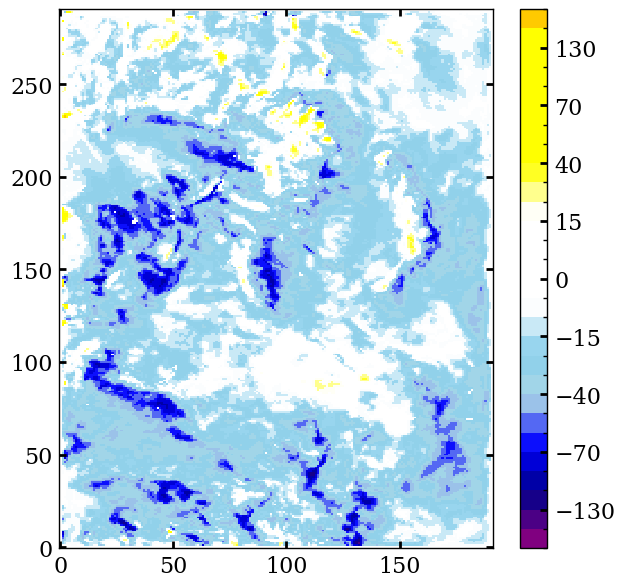

In [88]:

levs = [-200,-150,-130,-110,-90,-70,-60,-50,-40,-30,-20,-15,-10,-5,0,
        5,10,15,20,30,40,50,60,70,90,110,130,150,200]
levs = np.array(levs)
mycmap = ["purple","darkblue","blue","lightblue","skyblue",
          "white","white","white",
          "yellow","yellow","yellow","yellow","orange"]

colors_to_rgb = []
for ii in mycmap:
    aa = colors.to_rgba(ii)
    colors_to_rgb.append(aa)
stefan_cmap = LinearSegmentedColormap.from_list("t2",colors_to_rgb,len(levs)+1)

norm = matplotlib.colors.BoundaryNorm(levs,len(levs))
fig,ax = plt.subplots()
cb = ax.pcolormesh(diff_eoc.lon, diff_eoc.lat, diff_eoc,cmap=stefan_cmap,norm=norm)
plt.colorbar(cb)
plt.show()

In [21]:
## fig 1 data

plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc2.shp')
huc6 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc6.shp')
metapath = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'
coords1 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d01')
coords2 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d02')
coords4 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d04')
coords3 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d03')
coords_dict = {'d01': coords1, 
               'd02': coords2,
               'd03': coords3,
               'd04': coords4}



In [89]:
diff_eoc.to_netcdf('diff_eoc_d04.nc')

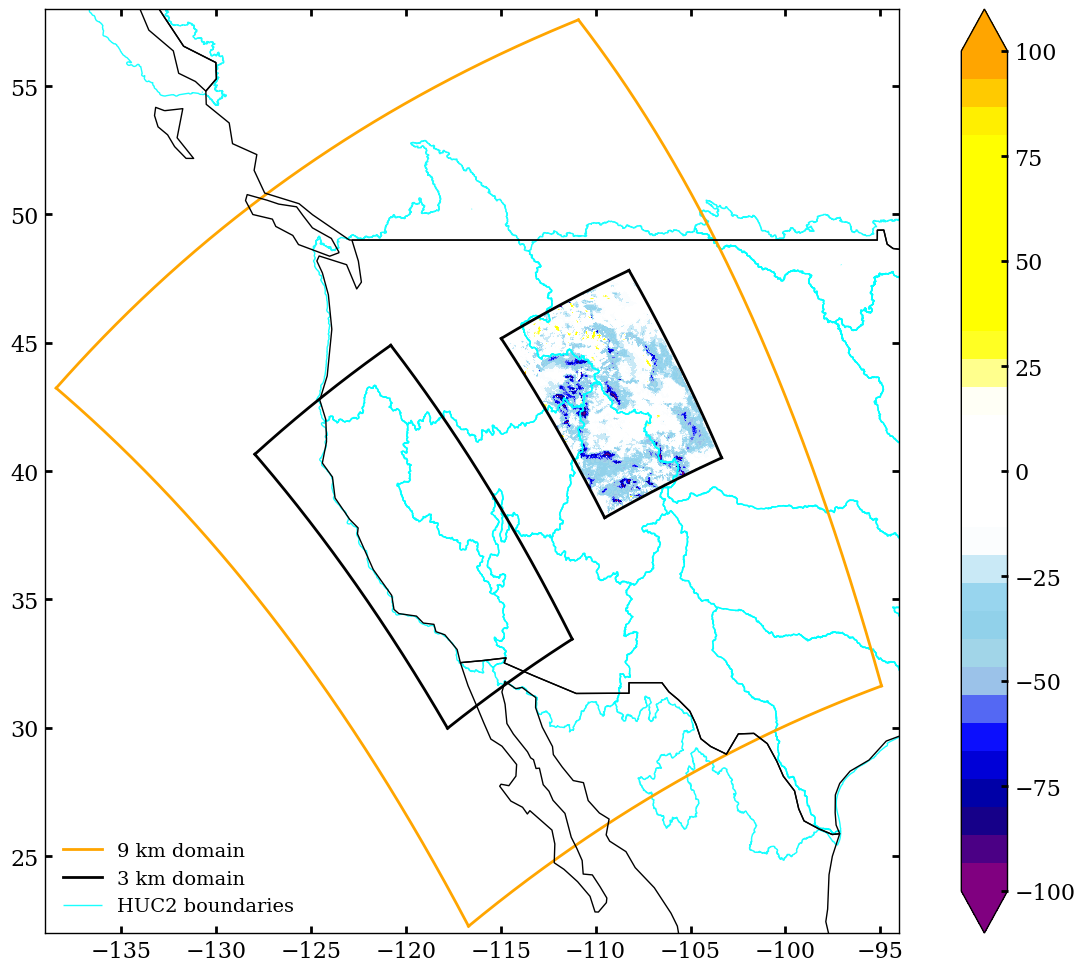

In [90]:
## make my own version of plotting for that one
import cmcrameri.cm as ccm
cmap = ccm.broc_r
cmap = stefan_cmap

## fig 1 code
clist = [[coords2, 'orange', -136.6 ,46.5, '9 km', 44],
         [coords3, 'black', -130 ,41, '3 km', 40],
         [coords4, 'black', -113 ,44.1, '  ', 40]]
fig,ax = plt.subplots(figsize=(16, 12))
for coords, color, lx, ly, l, rot in clist:
    ax.plot([0,1],[0,1], color = color, label = f'{l} domain')
    
    ax.plot(coords['XLONG'][0,:,0], coords['XLAT'][0,:,0], color =  color)
    ax.plot(coords['XLONG'][0,:,-1], coords['XLAT'][0,:,-1], color =  color)
    ax.plot(coords['XLONG'][0,0,:], coords['XLAT'][0,0,:], color = color)
    ax.plot(coords['XLONG'][0,-1,:], coords['XLAT'][0,-1,:], color = color)
    

cb = ax.pcolormesh(lon_wrf, lat_wrf, diff_eoc, cmap = cmap, vmin = -100, vmax = 100)
plt.colorbar(cb, extend = 'both')    

world.boundary.plot(ax=ax, linewidth =1 )
huc2.boundary.plot(ax=ax, linewidth = 1, label = 'HUC2 boundaries', color = 'cyan', alpha = 0.9, zorder = 1)
handles, labels = plt.gca().get_legend_handles_labels()
indices = [0,1,3] 
selected_handles = [handles[i] for i in indices]
selected_labels = [labels[i] for i in indices]
plt.legend(selected_handles, selected_labels, loc = 'lower left', 
           frameon = False)
ax.set_xlim((-139,-94))
ax.set_ylim((22,58))
plt.show()

In [ ]:
import cmcrameri.cm as ccm
fig,ax = plt.subplots(3,2, figsize = (15,20))
axs = ax.flatten()
yrs = [0,6,10]
style = {'lee': '--',
         'wind': '-',
         'prec': 'darkblue',
         'temp': 'orchid'}
yrcolors = ["black", "#332288","#88CCEE","#44AA99","#117733",
            "#999933","#DDCC77","#CC6677","#882255","#AA4499","brown","#fd3c06","gray"]

yrcolors = ["gray", "#88CCEE","#117733" ]


k = 0
custom_xtick_labels = ['1','0','1']
xtick_locations = [-1, 0,1]


for domain in domains[0:3]:
    sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
    sidenames = list(sidemasks.side.values)
    info = plot_info[domain]
    snow_elev = info['snow_elev']
    area = info['area']
    elev_bins = info['elev']
    coords = info['coords']
    lon_array = coords['XLONG'][0]
    lat_array = coords['XLAT'][0]
    swe = info['swe_mean']
    yrs = [0,6,10]
    cmap = ccm.bilbao_r # 'copper'
   
    for i, subregion in enumerate(sidenames):
        regmask = sidemasks.sel(side = subregion).basin_mask.values
        diff = np.nanmean(swe['snow'][-30:].where(regmask), axis = (0)) - np.nanmean(swe['snow'][0:30].where(regmask), axis = 0)
        axs[k].pcolormesh(lon_array, lat_array,diff, cmap = cmap, vmin = -700, vmax = 0)
        snowdata = snow_elev[subregion]
        axs[k].set_xlim((-121, -118))
        axs[k].set_ylim((36,39.5))
        for idx,yr in enumerate(yrs):
            data = (snowdata[yr]) 
            label = None
            if subregion == 'wind': 
                data = -data
                label = yr * 10  +1980
            axs[k+1].plot(data,   #/ np.abs(np.nanmax(np.abs(data))) , 
                    elev_bins[1:], linestyle =style[subregion], 
                    color = yrcolors[idx] ,label =  label)
    in_sn.loc[idx_lee].boundary.plot(ax=axs[k], color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axs[k], color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axs[k], color =  '#332288' )#'purple')

    k+=2
    
    
    